In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd
import matplotlib.patches as patches

In [3]:
df_train = pd.read_csv("../input/rsna-breast-cancer-detection/train.csv")
flist = [str(patient) for patient in pathlib.Path("../data/dicom2png_256").glob("*/*.png")]

In [220]:
flist[0].split("/")[-2] 

'1069'

In [188]:
df_train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [213]:
df_train.query("patient_id==10006 & image_id==1459541791")["laterality"].values[0]

'L'

In [192]:
len(df_train["image_id"].unique())

54706

In [224]:
def load_img(path, gray=False):
    img = cv2.imread(path)
    if gray : 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def isLateralityR(df, patient_id, image_id):
    lat = df.query(f"patient_id == {patient_id} & image_id == {image_id}")["laterality"].values[0]
    if lat == "R" : 
        return True
    else :
        return False

def get_row(df, patient_id, image_id):
    return df.query(f"patient_id == {patient_id} & image_id == {image_id}")


In [216]:
isLateralityR(df_train, 10006, 1874946579)

R <class 'str'>


True

3
2


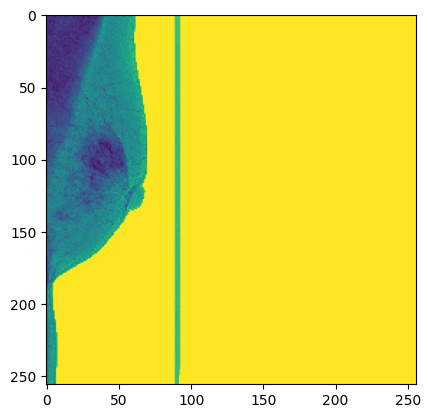

In [235]:
img = cv2.imread("../data/dicom2png_256/10006/1459541791.png")
print(len(img.shape))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(len(img.shape))
plt.imshow(img)

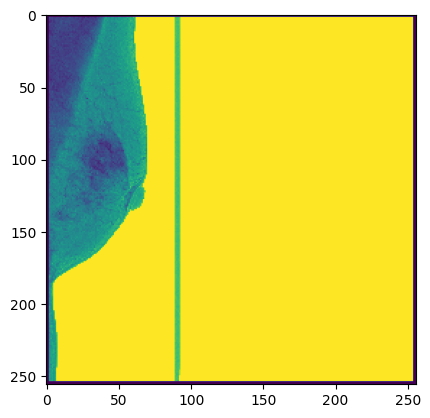

In [74]:
img = cv2.imread("../data/dicom2png_256/10006/1459541791.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, bin_img = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
img = cv2.drawContours(img, contours, -1, (0, 0, 255), 2)
plt.imshow(img)

(256, 256)
2


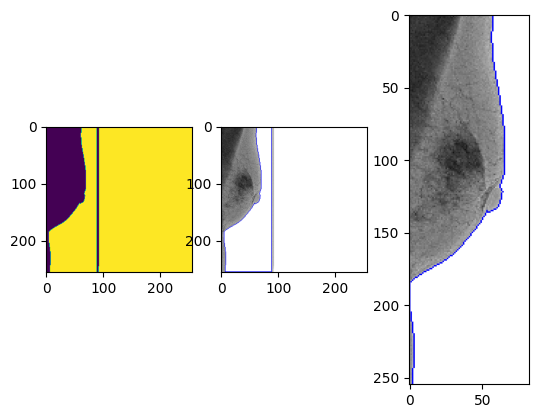

In [237]:

# 画像を読み込む。
# img = cv2.imread("sample.png")
img = cv2.imread("../data/dicom2png_256/10006/1459541791.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 2値化する
# 精度に直結する
ret, bin_img = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
# imshow(bin_img)
print(bin_img.shape)
fig, ax = plt.subplots(1,3)
ax[0].imshow(bin_img)
# 輪郭を抽出する。
contours, hierarchy = cv2.findContours( bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
# 小さい輪郭は誤検出として削除する
contours = list(filter(lambda x: cv2.contourArea(x) > 100, contours))
# 輪郭点が少ないものは削除する
contours = list(filter(lambda x: len(x) > 10, contours))
# 輪郭を描画する。
cv2.drawContours(img, contours, -1, color=(0, 0, 255), thickness=1)

ax[1].imshow(img)

xmin, xmax = np.min(contours[0][:,:,0]), np.max(contours[0][:,:,0])
ymin, ymax = np.min(contours[0][:,:,1]), np.max(contours[0][:,:,1])
ax[2].imshow(img[ymin:ymax, xmin:xmax,:])

In [239]:
img2 = img[ymin:ymax, xmin:xmax,:]
img2.shape

(255, 83, 3)

In [232]:
def get_breast(fname):
    # グレースケール
    orig = cv2.imread(fname)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 右なら反転 
    patient_id = fname.split("/")[-2]
    image_id = fname.split("/")[-1].replace(".png", "")
    if isLateralityR(df_train, patient_id, image_id): 
        img = np.fliplr(img)
        gray = np.fliplr(gray)

    # 背景が白か黒か判定
    if np.mean(gray.flatten()) < 100:
        gray = cv2.bitwise_not(gray)

    # 2値化する
    # 精度に直結する
    ret, bin_img = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # 輪郭を抽出する。
    # contours, hierarchy = cv2.findContours( bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv2.findContours( bin_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)# SIMPLE)

    # cleanings
    #   - 小さい輪郭は誤検出として削除する
    # contours = list(filter(lambda x: cv2.contourArea(x) > 100, contours))
    #   - 最も輪郭点が多いものを胸部とする
    # contours = list(filter(lambda x: len(x) > 10, contours))
    max_size = -999
    max_contour = None
    for idx, c in enumerate(contours):
        if len(c) > max_size:
            max_size = len(c)
            max_contour = c
    # 輪郭を描画する。
    # cv2.drawContours(img, contours, -1, color=(0, 0, 255), thickness=1)

    xmin, xmax = np.min(max_contour[:,:,0]), np.max(max_contour[:,:,0])
    ymin, ymax = np.min(max_contour[:,:,1]), np.max(max_contour[:,:,1])
    crop_img = img[ymin:ymax, xmin:xmax,:]

    return orig, bin_img, crop_img, contours, max_contour

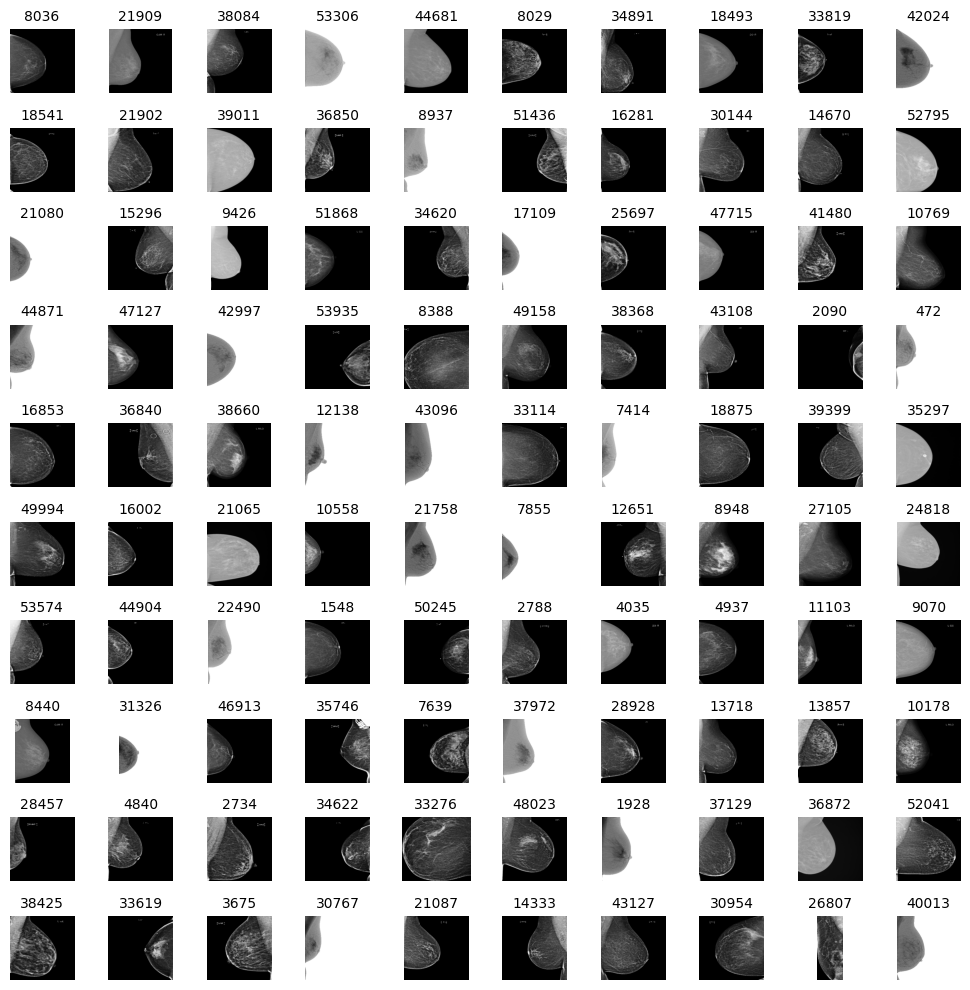

In [233]:
fig, axs = plt.subplots(10,10,figsize=(10,10))
axs = axs.flatten()
for ax in axs:
    idx = np.random.randint(0, len(flist))
    fname = flist[idx]
    orig, bin_img, crop_img, _, _ = get_breast(fname)
    ax.imshow(crop_img)
    ax.axis("off")
    ax.set_title(idx, fontsize=10)
plt.tight_layout()

In [225]:
flist[215]
get_row(df_train, 40143, 1570177376)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
28223,1,40143,1570177376,L,CC,69.0,0,0,0,NaN,0,B,49,False


../data/dicom2png_256/38078/1176374976.png


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
26258,1,38078,1176374976,L,MLO,61.0,0,0,0,NaN,0,C,49,False


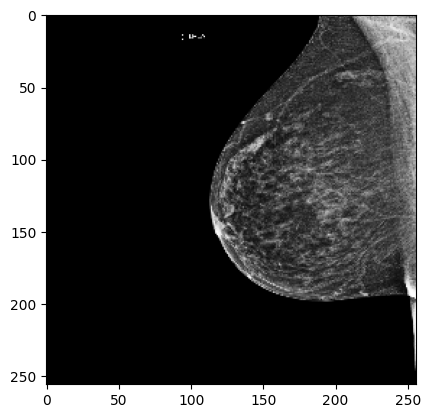

In [229]:
fname = flist[51939] 
print(fname)

img = load_img(fname)
plt.imshow(img)

get_row(df_train, fname.split("/")[-2], fname.split("/")[-1].replace(".png",""))

196.2440643310547


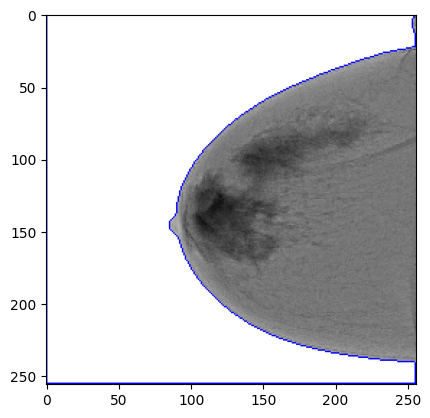

In [183]:
orig, bin_img, crop_img, contours, max_contour = get_breast(flist[8101])
plt.imshow(crop_img)
plt.imshow(bin_img)
plt.imshow(orig)
print(np.mean(orig.flatten()))
cv2.drawContours(orig, contours, -1, color=(0, 0, 255), thickness=1)
plt.imshow(orig)
# plt.imshow(cv2.bitwise_not(orig))

196.2440643310547


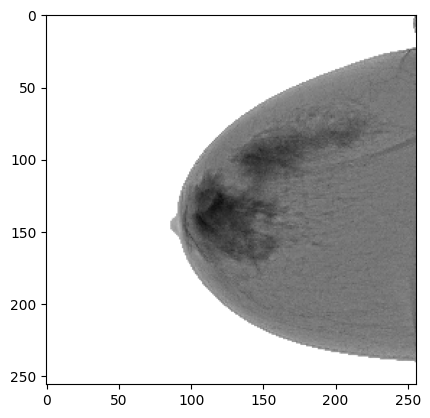

In [ ]:
orig, bin_img, crop_img, contours, max_contour = get_breast(flist[8101])
plt.imshow(crop_img)
plt.imshow(bin_img)
plt.imshow(orig)
print(np.mean(orig.flatten()))
plt.imshow(orig)
# plt.imshow(cv2.bitwise_not(orig))

196.2440643310547


(array([4.89000e+02, 2.41500e+03, 6.15000e+03, 1.29960e+04, 5.19510e+04,
        6.49200e+03, 7.44000e+02, 2.10000e+01, 3.30000e+01, 1.15317e+05]),
 array([ 12. ,  36.3,  60.6,  84.9, 109.2, 133.5, 157.8, 182.1, 206.4,
        230.7, 255. ]),
 <BarContainer object of 10 artists>)

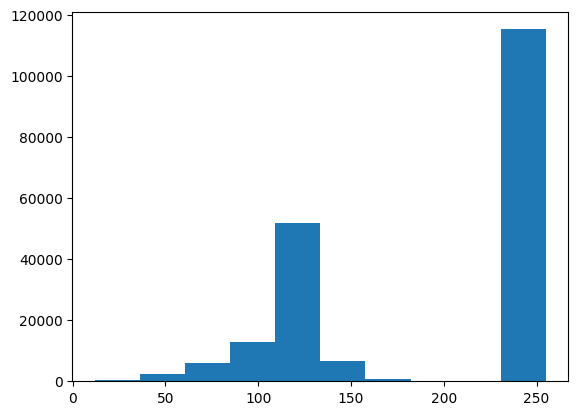

In [179]:
print(np.mean(orig.flatten()))
plt.hist(orig.flatten())

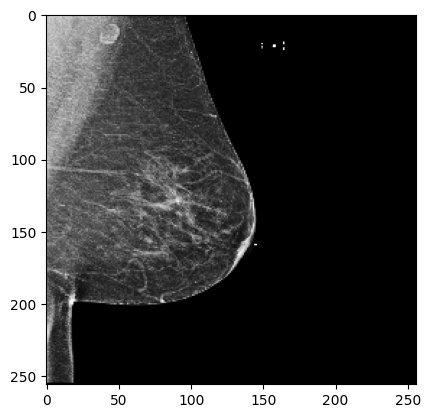

In [152]:
orig, bin_img, crop_img, contours, max_contour = get_breast(flist[16110])
plt.imshow(crop_img)
plt.imshow(bin_img)
plt.imshow(orig)
# plt.imshow(cv2.bitwise_not(orig))

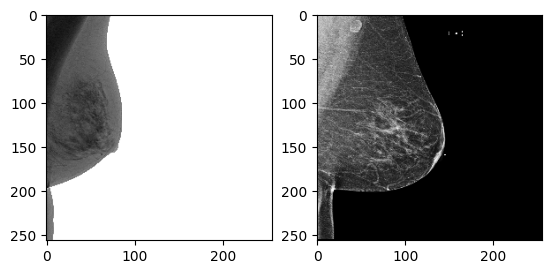

In [172]:
img1 = load_img(flist[14218])
img2 = load_img(flist[16110])

fig, ax = plt.subplots(1,2)
ax[0].imshow(img1)
ax[1].imshow(img2)

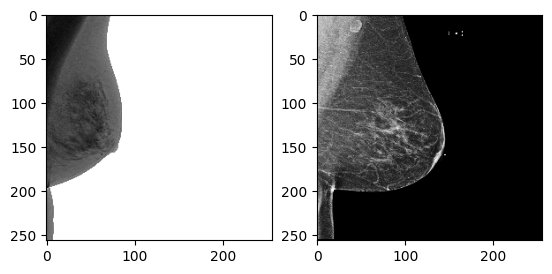

In [175]:
img1 = load_img(flist[14218], gray=True)
img2 = load_img(flist[16110], gray=True)

fig, ax = plt.subplots(1,2)
ax[0].imshow(img1, cmap="gray")
ax[1].imshow(img2, cmap="gray")

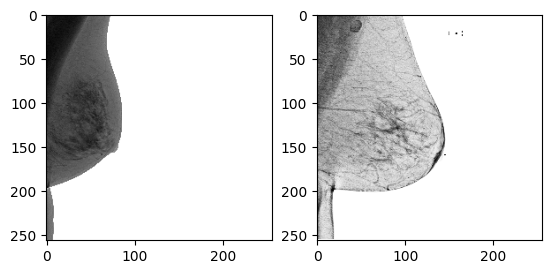

In [176]:
img1 = load_img(flist[14218], gray=True)
img2 = load_img(flist[16110], gray=True)

fig, ax = plt.subplots(1,2)
ax[0].imshow(img1, cmap="gray")
ax[1].imshow(cv2.bitwise_not(img2), cmap="gray")

215.6678009033203 33.256195068359375


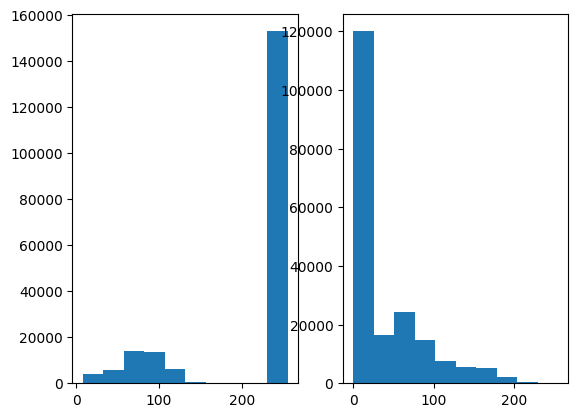

In [162]:
fig, ax = plt.subplots(1,2)
ax[0].hist(img1.flatten())
ax[1].hist(img2.flatten())
print(np.mean(img1), np.mean(img2))

(array([3.82200e+03, 5.82900e+03, 1.39530e+04, 1.33740e+04, 6.29700e+03,
        4.08000e+02, 9.00000e+00, 1.50000e+01, 1.20000e+01, 1.52889e+05]),
 array([  8. ,  32.7,  57.4,  82.1, 106.8, 131.5, 156.2, 180.9, 205.6,
        230.3, 255. ]),
 <BarContainer object of 10 artists>)

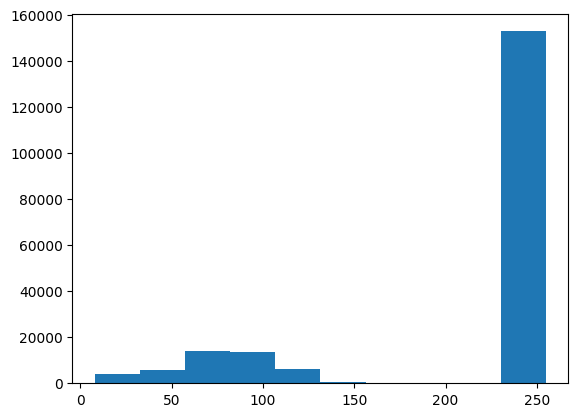

In [ ]:
plt.hist(img1.flatten())

In [112]:
img.shape

(256, 256, 3)

In [110]:
xmin, xmax = np.min(contours[0][:,:,0]), np.max(contours[0][:,:,0])
ymin, ymax = np.min(contours[0][:,:,1]), np.max(contours[0][:,:,1])

In [98]:
contours[0]

array([[[ 93,   0]],

       [[ 93, 245]],

       [[ 92, 246]],

       [[ 92, 255]],

       [[255, 255]],

       [[255,   0]]], dtype=int32)

In [100]:
contours[1].shape

(89, 1, 2)

ValueError: x and y can be no greater than 2D, but have shapes (89,) and (89, 1, 2)

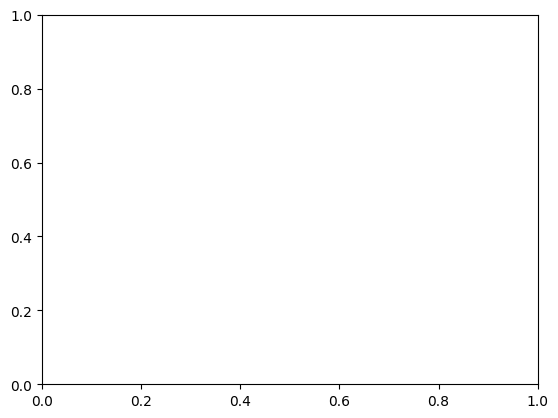

In [93]:
plt.plot(contours[1])

(array([[[202, 296]]], dtype=int32), array([[[260, 272]]], dtype=int32), array([[[258, 272]],

       [[256, 274]],

       [[257, 274]],

       [[258, 273]]], dtype=int32), array([[[287, 250]],

       [[287, 251]]], dtype=int32), array([[[288, 247]],

       [[288, 248]]], dtype=int32), array([[[298, 232]],

       [[297, 233]],

       [[297, 234]],

       [[296, 235]],

       [[296, 237]],

       [[297, 237]],

       [[298, 236]]], dtype=int32), array([[[302, 230]],

       [[301, 231]],

       [[300, 231]],

       [[301, 232]],

       [[301, 235]],

       [[300, 236]],

       [[302, 236]],

       [[303, 235]],

       [[303, 233]],

       [[304, 232]],

       [[304, 230]],

       [[303, 231]]], dtype=int32), array([[[307, 228]]], dtype=int32), array([[[325, 196]],

       [[324, 197]],

       [[325, 197]]], dtype=int32), array([[[ 82, 130]]], dtype=int32), array([[[302, 113]]], dtype=int32), array([[[181,  66]],

       [[182,  67]],

       [[181,  68]],

       [[

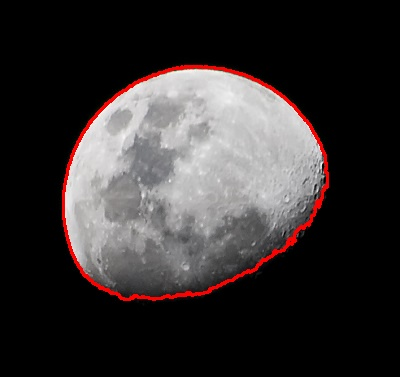

In [63]:
# 輪郭を抽出する。
contours, hierarchy = cv2.findContours(
    bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
print(contours)

# 小さい輪郭は誤検出として削除する
contours = list(filter(lambda x: cv2.contourArea(x) > 100, contours))

# 輪郭を描画する。
cv2.drawContours(img, contours, -1, color=(0, 0, 255), thickness=2)

imshow(img)

In [45]:
hierarchy

array([[[-1, -1, -1, -1]]], dtype=int32)

In [48]:
contours[0].shape

(1020, 1, 2)

In [42]:
bkg = np.zeros((256,256,3))
cv2.drawContours(bkg, contours, -1, (0, 0, 255), 2)
bkg = cv2.cvtColor(bkg, cv2.COLOR_GRAY2BGR)
plt.imshow(bkg)

error: OpenCV(4.7.0) /Users/opencv-cn/GHA-OCV-2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 3


In [20]:
contours

(array([[[  0,   0]],
 
        [[  0, 255]],
 
        [[255, 255]],
 
        [[255,   0]]], dtype=int32),)

In [4]:
def crop_coords(img):
    """
    Crop ROI from image.
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return (x, y, w, h)


def truncation_normalization(img):
    """
    Clip and normalize pixels in the breast ROI.
    @img : numpy array image
    return: numpy array of the normalized image
    """
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[img==0]=0
    return normalized


def clahe(img, clip):
    """
    Image enhancement.
    @img : numpy array image
    @clip : float, clip limit for CLAHE algorithm
    return: numpy array of the enhanced image
    """
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

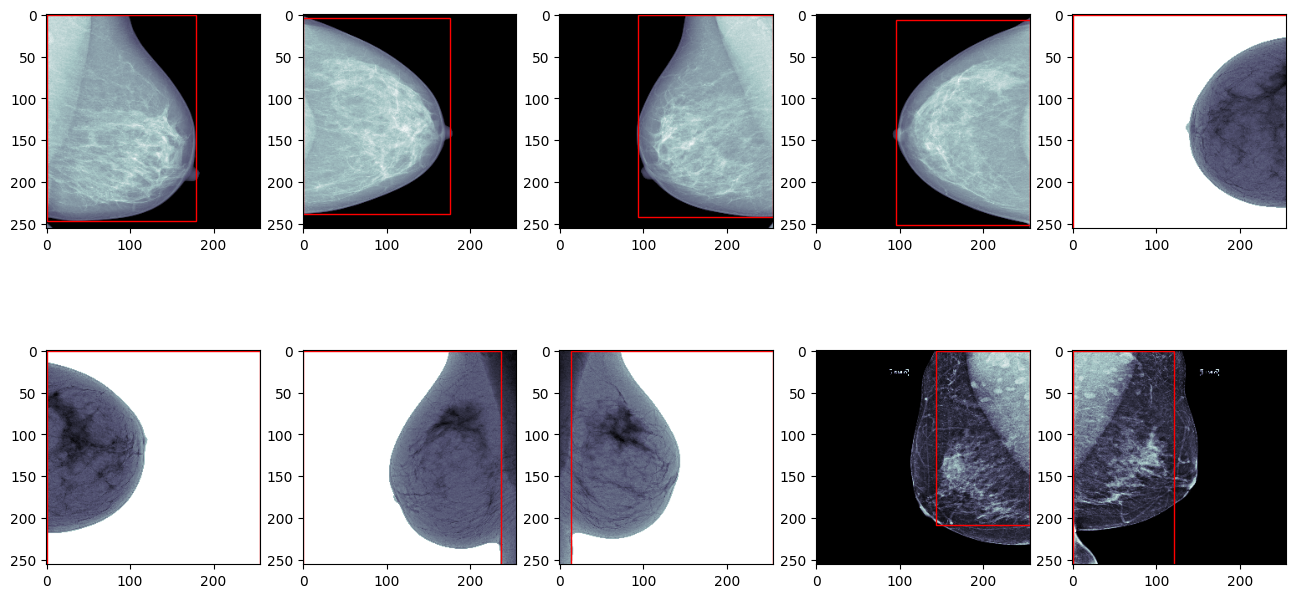

In [5]:
_, axs = plt.subplots(2, 5, figsize=(16, 8))
axs = axs.flatten()
images = []
for img_path, ax in zip(flist[:10], axs):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    (x, y, w, h) = crop_coords(img)
    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    img_cropped = img[y:y+h, x:x+w]
    images.append(img_cropped)
    ax.imshow(img, cmap="bone")

plt.savefig("rectangles.png")
plt.show()

In [ ]:
IMG_SIZE = 512

for img_path, ax in zip(flist[:10], axs):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    (x, y, w, h) = crop_coords(img)
    img_cropped = img[y:y+h, x:x+w]
    images.append(img_cropped)
    
    img_normalized = truncation_normalization(img_cropped)
    
    # Enhancing the contrast of the image.
    cl1 = clahe(img_normalized, 1.0)
    cl2 = clahe(img_normalized, 2.0)
    img_final = cv2.merge((np.array(img_normalized*255, dtype=np.uint8),cl1,cl2))
    
    # Resize the image to the final shape. 
    img_final = cv2.resize(img_final, (IMG_SIZE, IMG_SIZE))

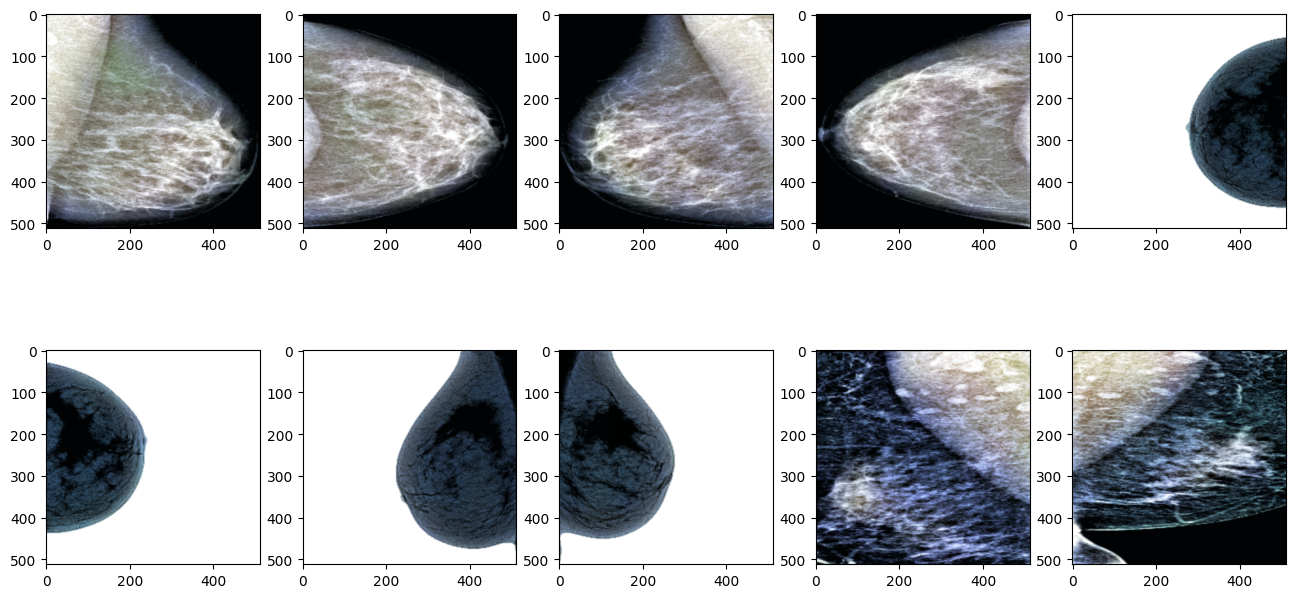

In [6]:
_, axs = plt.subplots(2, 5, figsize=(16, 8))
axs = axs.flatten()
final_imgs = []
IMG_SIZE = 512
for img_cropped, ax in zip(images, axs):
    img_normalized = truncation_normalization(img_cropped)
    # Enhancing the contrast of the image.
    cl1 = clahe(img_normalized, 1.0)
    cl2 = clahe(img_normalized, 2.0)
    img_final = cv2.merge((np.array(img_normalized*255, dtype=np.uint8),cl1,cl2))
    # Resize the image to the final shape. 
    img_final = cv2.resize(img_final, (IMG_SIZE, IMG_SIZE))
    ax.imshow(img_final)
    